# Evaluate impact of damage function location

In [34]:
# Copyright 2023 Richard Laugesen

# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at

#     https://www.apache.org/licenses/LICENSE-2.0

# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [35]:
import sys
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import pickle
import bz2
from scipy import stats
import matplotlib.ticker as ticker

sys.path.append('..')

from ruv.relative_utility_value import *
from ruv.damage_functions import *
from ruv.economic_models import *
from ruv.utility_functions import *

In [36]:
plt.rcParams['figure.figsize'] = (8, 7)

plt.rcParams['font.family'] = "calibri"
plt.rcParams['font.size'] = "12.5"

colors = {
    'black': '#000000',
    'light_orange': '#E69F00',
    'light_blue': '#56B4E9',
    'green': '#009E73',
    'yellow': '#F0E442',
    'dark blue': '#0072B2',
    'dark_orange': '#D55E00',
    'pink': '#CC79A7'
} 

# Example forecast dataset
### Day 1 to 7 forecasts for catchment in southern Murray-Darling basin generated using the MuTHRE method

In [37]:
awrc = '401012'
dataset_filepath = '%s_data.pickle.bz2' % awrc
parallel_nodes = 4
k = 1.5
thresholds_step = 0.05

In [38]:
with bz2.BZ2File(dataset_filepath, 'r') as f:
    data = pickle.load(f)
obs, clim_ens, fcst_ens = data['obs'], data['clim'].T, data['fcst'].T
print(obs.shape, fcst_ens.shape, clim_ens.shape)

(1932,) (1932, 100) (1932, 484)


# Define decision context

In [39]:
decision_definition = {
    'alphas': np.array([0.1, 0.5, 0.9]),
    'utility_function': [cara, {'A': 0.3}],                                  # minor risk aversion
    'economic_model': [cost_loss, cost_loss_analytical_spend],
    'decision_thresholds': None,
    'decision_method': 'optimise_over_forecast_distribution',
    'damage_function': [logistic, {'k': k, 'A': 1, 'threshold': np.nanquantile(obs, 0.99)}]
}

ref = clim_ens  # use 14-day moving average climatology as the reference forecast

# Plot sample damage functions

In [40]:
thresholds = np.arange(0, np.nanmax(obs) * 1.3, thresholds_step)

In [41]:
show_percentiles = False

def flow_to_percentile(x):
    return stats.percentileofscore(obs[~np.isnan(obs)], x)

def percentile_to_flow(x):
    return np.nanpercentile(obs, x)

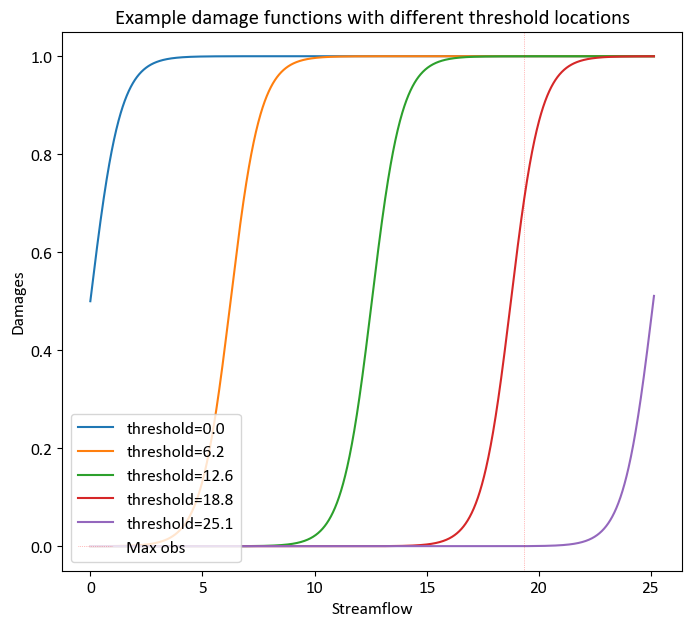

In [42]:
streamflow = np.arange(0, np.nanmax(obs), 0.01) * 1.3
damage_fnc, params = decision_definition['damage_function']

ax = plt.axes()

for threshold in thresholds[[0, int(len(thresholds)/4), int(len(thresholds)/2), 3*int(len(thresholds)/4), len(thresholds)-1]]:
    params['threshold'] = threshold
    damages = damage_fnc(params)(streamflow)
    plt.plot(streamflow, damages, label='threshold=%.1f' % params['threshold'])

plt.axvline(np.nanmax(obs), color='red', linewidth=0.5, alpha=0.5, linestyle='dotted', label='Max obs')

if show_percentiles:
    plt.xlim((0, np.nanmax(obs)))
    secax = ax.secondary_xaxis(-0.15, functions=(flow_to_percentile, percentile_to_flow))
    secax.xaxis.set_major_locator(ticker.FixedLocator([50, 90, 99, 99.9, 100]))
    secax.set_xlabel('Percentile')

plt.title('Example damage functions with different threshold locations')
plt.xlabel('Streamflow')
plt.ylabel('Damages')
plt.legend(loc='lower left')

# Calculate RUV for the different shape logistic damage functions

In [43]:
results = {}
for threshold in thresholds:
    decision_definition['damage_function'] = [logistic, {'k': k, 'A': 1, 'threshold': threshold}]
    results[threshold] = relative_utility_value(obs, fcst_ens, ref, decision_definition, parallel_nodes=parallel_nodes)['ruv']

results_df = pd.DataFrame(results, index=decision_definition['alphas']).T
#results_df

# Plot results for different values of alpha

In [44]:
show_percentiles = True

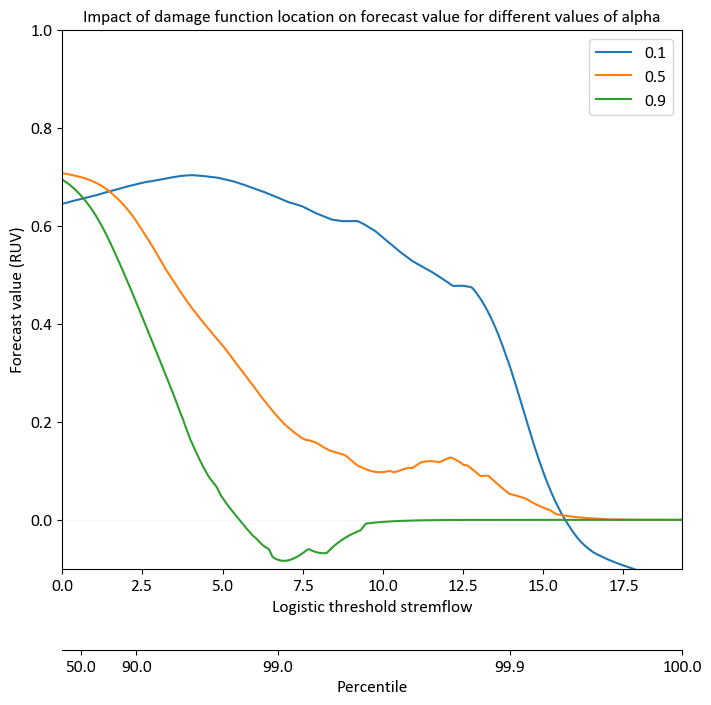

In [45]:
ax = results_df.plot()
plt.axhline(0, color='grey', linewidth=0.5, alpha=0.3, linestyle='dotted')
#plt.axvline(np.nanmax(obs), color='red', linewidth=0.5, alpha=0.5, linestyle='dotted', label='Max obs')

plt.ylim(-0.1, 1)

if show_percentiles:
    plt.xlim((0, np.nanmax(obs)))
    secax = ax.secondary_xaxis(-0.15, functions=(flow_to_percentile, percentile_to_flow))
    secax.xaxis.set_major_locator(ticker.FixedLocator([50, 90, 99, 99.9, 100]))
    secax.set_xlabel('Percentile')

plt.xlabel('Logistic threshold stremflow')
plt.ylabel('Forecast value (RUV)')
plt.title('Impact of damage function location on forecast value for different values of alpha', fontsize='medium')
plt.legend()